# **Web Scraping for Company Insights & Predicting Customer Buying Behaviours**

### **Import Libraries**

In [46]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

### **Web Scraping**

In [47]:
base_url = "https://www.airlinequality.com/airline-reviews/air-india/"
pages = 10
page_size = 100

data = []
for i in range(1, pages + 1):

    print(f"Scraping page {i}")
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    response = requests.get(url)
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        data.append(para.get_text())

    print(f"   ---> {len(data)} total reviews")


Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [48]:
df = pd.DataFrame()
df["data"] = data
df.head()

,data
0,✅ Trip Verified | Requested a gluten free mea...
1,Not Verified | Worst planes I have ever been i...
2,Not Verified | I have been flying for the past...
3,✅ Trip Verified | Sometime around 2017 I got t...
4,Not Verified | My flight was supposed to depa...


In [49]:
df.to_csv("data.csv")
df.head()

,data
0,✅ Trip Verified | Requested a gluten free mea...
1,Not Verified | Worst planes I have ever been i...
2,Not Verified | I have been flying for the past...
3,✅ Trip Verified | Sometime around 2017 I got t...
4,Not Verified | My flight was supposed to depa...


## **Data Preprocessing**

### **Data Cleaning**

**Remove sentences before '|' in data column**

In [50]:
df.data= df.data.str.split('|',expand=True)[1]

In [51]:
df

,data
0,Requested a gluten free meal and was given a...
1,Worst planes I have ever been in while taking...
2,I have been flying for the past 21 years and ...
3,Sometime around 2017 I got the patriotism bug...
4,My flight was supposed to depart New Delhi a...
...,...
995,None
996,None
997,None
998,None


**Remove all special characters**

In [52]:
# import request as re
import re

In [53]:
def clean(text):
    text = re.sub('[^A-Za-z]+]', ' ', str(text))
    return text

In [54]:
df['clean_data'] = df['data'].apply(clean)
df.head()

,data,clean_data
0,Requested a gluten free meal and was given a...,Requested a gluten free meal and was given a...
1,Worst planes I have ever been in while taking...,Worst planes I have ever been in while taking...
2,I have been flying for the past 21 years and ...,I have been flying for the past 21 years and ...
3,Sometime around 2017 I got the patriotism bug...,Sometime around 2017 I got the patriotism bug...
4,My flight was supposed to depart New Delhi a...,My flight was supposed to depart New Delhi a...


### **Tokenization**

#### **Import Libraries**

In [55]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### **POS Tagging**

In [56]:
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [57]:
# converting each token into tuple
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
          newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

In [58]:
df['POS tagged'] = df['clean_data'].apply(token_stop_pos)
df.head()

,data,clean_data,POS tagged
0,Requested a gluten free meal and was given a...,Requested a gluten free meal and was given a...,"[(Requested, v), (gluten, a), (free, a), (meal..."
1,Worst planes I have ever been in while taking...,Worst planes I have ever been in while taking...,"[(Worst, n), (planes, n), (ever, r), (taking, ..."
2,I have been flying for the past 21 years and ...,I have been flying for the past 21 years and ...,"[(flying, v), (past, a), (21, None), (years, n..."
3,Sometime around 2017 I got the patriotism bug...,Sometime around 2017 I got the patriotism bug...,"[(Sometime, r), (around, None), (2017, None), ..."
4,My flight was supposed to depart New Delhi a...,My flight was supposed to depart New Delhi a...,"[(flight, n), (supposed, v), (depart, v), (New..."


#### **Lemmatization (Lemma)**

In [59]:
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

In [60]:
# grouping the words
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
     if not pos:
        lemma = word
        lemma_rew = lemma_rew + " " + lemma
     else:
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

In [61]:
df['Lemma'] = df['POS tagged'].apply(lemmatize)
df.head()

,data,clean_data,POS tagged,Lemma
0,Requested a gluten free meal and was given a...,Requested a gluten free meal and was given a...,"[(Requested, v), (gluten, a), (free, a), (meal...",Requested gluten free meal give regular meal...
1,Worst planes I have ever been in while taking...,Worst planes I have ever been in while taking...,"[(Worst, n), (planes, n), (ever, r), (taking, ...",Worst plane ever take international flight ....
2,I have been flying for the past 21 years and ...,I have been flying for the past 21 years and ...,"[(flying, v), (past, a), (21, None), (years, n...",fly past 21 year never see poorly condition ...
3,Sometime around 2017 I got the patriotism bug...,Sometime around 2017 I got the patriotism bug...,"[(Sometime, r), (around, None), (2017, None), ...",Sometime around 2017 get patriotism bug . av...
4,My flight was supposed to depart New Delhi a...,My flight was supposed to depart New Delhi a...,"[(flight, n), (supposed, v), (depart, v), (New...",flight suppose depart New Delhi 2300hrs . fi...


In [62]:
df[['data','Lemma']]

,data,Lemma
0,Requested a gluten free meal and was given a...,Requested gluten free meal give regular meal...
1,Worst planes I have ever been in while taking...,Worst plane ever take international flight ....
2,I have been flying for the past 21 years and ...,fly past 21 year never see poorly condition ...
3,Sometime around 2017 I got the patriotism bug...,Sometime around 2017 get patriotism bug . av...
4,My flight was supposed to depart New Delhi a...,flight suppose depart New Delhi 2300hrs . fi...
...,...,...
995,None,None
996,None,None
997,None,None
998,None,None


## **Sentiment Analysis**

### **VADER - Valence Aware Dictionary for Sentiment Reasoning**

In [63]:
# import libraries
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [64]:
# for calculating sentiment analysis
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

df['Sentiment'] = df['Lemma'].apply(vadersentimentanalysis)

In [65]:
# function to analyzing
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0 :
        return 'Negative'
    else:
        return 'Neutral'

df['Analysis'] = df['Sentiment'].apply(vader_analysis)
df.head()

,data,clean_data,POS tagged,Lemma,Sentiment,Analysis
0,Requested a gluten free meal and was given a...,Requested a gluten free meal and was given a...,"[(Requested, v), (gluten, a), (free, a), (meal...",Requested gluten free meal give regular meal...,0.6249,Positive
1,Worst planes I have ever been in while taking...,Worst planes I have ever been in while taking...,"[(Worst, n), (planes, n), (ever, r), (taking, ...",Worst plane ever take international flight ....,0.7843,Positive
2,I have been flying for the past 21 years and ...,I have been flying for the past 21 years and ...,"[(flying, v), (past, a), (21, None), (years, n...",fly past 21 year never see poorly condition ...,-0.8134,Negative
3,Sometime around 2017 I got the patriotism bug...,Sometime around 2017 I got the patriotism bug...,"[(Sometime, r), (around, None), (2017, None), ...",Sometime around 2017 get patriotism bug . av...,-0.9728,Negative
4,My flight was supposed to depart New Delhi a...,My flight was supposed to depart New Delhi a...,"[(flight, n), (supposed, v), (depart, v), (New...",flight suppose depart New Delhi 2300hrs . fi...,-0.7351,Negative


In [66]:
# Final Analysis
vader_counts = df['Analysis'].value_counts()
vader_counts

Negative    384
Neutral     321
Positive    295
Name: Analysis, dtype: int64

### **Data Visualization Using Matplotlib**

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

([<matplotlib.patches.Wedge at 0x7e5650c9fac0>,
 [Text(0.3920530558072629, 1.0277618408134188, 'Negative'),
  Text(-1.0572819482786315, -0.30357022555603425, 'Neutral'),
  Text(0.8105673486638398, -1.079574255565625, 'Positive')],
 [Text(0.2138471213494161, 0.5605973677164102, '38.4%'),
  Text(-0.576699244515617, -0.16558375939420047, '32.1%'),
  Text(0.5103572195290843, -0.6797319386894675, '29.5%')])

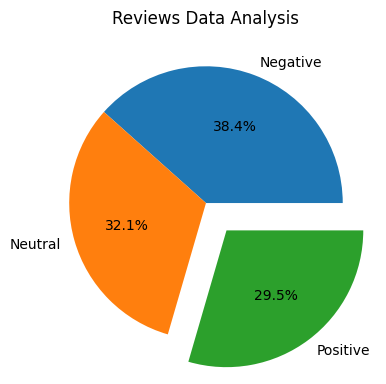

In [68]:
plt.figure(figsize=(15,7))
plt.subplot(1, 3, 2)
plt.title('Reviews Data Analysis')
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

### **Coverting To CSV File**

In [69]:
df.to_csv("AI_Data.csv")

### **Data Viz Using WordCloud**

In [70]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

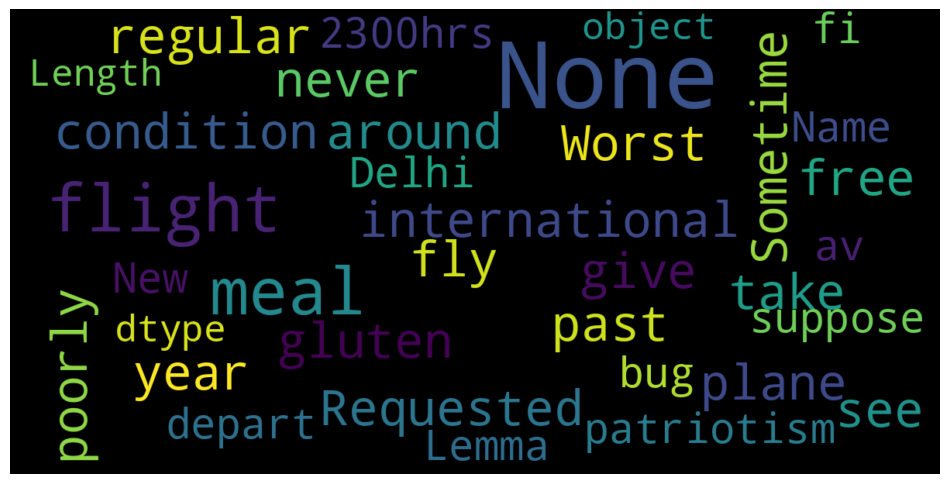

In [71]:
import wordcloud
def show_wordcloud(data):
  wordcloud = WordCloud(
      background_color = 'black',
      stopwords=stopwords,
      max_words = 200,
      max_font_size = 40,
      scale = 3,
      random_state = 1)

  wordcloud = wordcloud.generate(str(data))

  fig = plt.figure(1, figsize = (12, 32))
  plt.axis('off')

  plt.imshow(wordcloud, interpolation = 'Bilinear')
  plt.show()

show_wordcloud(df.Lemma)